# import data

In [1]:
import platform
import pandas as pd
from datetime import datetime, timedelta, time
ohlcv_data = pd.read_pickle('/Users/bokie/code/python/CMS/可转债套利/cms/stock_data_min_new.pkl')
print(ohlcv_data.keys())
for k,v in ohlcv_data.items():
    print(k,' data length: ',len(v))
print('数据起始日期',v.index[0])
print('数据结束日期',v.index[-1])
print('113642.SH数据起始日期',ohlcv_data['113642.SH'].index[0])
print('113642.SH数据结束日期',ohlcv_data['113642.SH'].index[-1])

dict_keys(['123046.SZ', '300587.SZ', '113642.SH', '603185.SH', '110061.SH', '600674.SH', '128081.SZ', '002203.SZ'])
123046.SZ  data length:  31460
300587.SZ  data length:  31460
113642.SH  data length:  13552
603185.SH  data length:  31460
110061.SH  data length:  31460
600674.SH  data length:  31460
128081.SZ  data length:  31460
002203.SZ  data length:  31460
数据起始日期 2021-12-13 09:30:00
数据结束日期 2022-06-28 15:00:00
113642.SH数据起始日期 2022-04-06 09:30:00
113642.SH数据结束日期 2022-06-28 15:00:00


# bond-stock pair

In [2]:
# cbond_pair = ['128081.SZ','002203.SZ']
# part = 1
# convert_price = 9.69
# stock_volume = 100/convert_price #整个回测期间不变


cbond_pair = ['123046.SZ','300587.SZ']
part = 1 
convert_price = 6.73
# stock_volume = 100/convert_price  # 2021-12-13至2022-03-22   # 等于可转债的前收盘价/股票的前收盘价
# part = 2
# convert_price = 6.74
# stock_volume = 100/convert_price  # 2022-03-23至2022-06-28


# cbond_pair = ['110061.SH','600674.SH']
# part = 1
# convert_price = 9.2
# stock_volume = 100/convert_price #整个回测期间不变


# cbond_pair = ['113642.SH','603185.SH']
# part = 1
# convert_price = 145.66
# stock_volume = 100/convert_price  # 2022-04-06至2022-06-01
# part = 2
# convert_price = 102.61
# stock_volume = 100/convert_price  # 2022-06-02至2022-06-28


In [3]:
cbond_pair_price = pd.DataFrame([])
cbond_pair_price = pd.concat([ohlcv_data[cbond_pair[0]]['close'],ohlcv_data[cbond_pair[1]]['close']],axis=1)
cbond_pair_price.columns = cbond_pair
cbond_pair_price = cbond_pair_price.dropna()
if cbond_pair[0] == '128081.SZ' or cbond_pair[0] == '110061.SH':
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':]
elif cbond_pair[0] == '123046.SZ' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':'2022-03-22 15:00:00']
elif cbond_pair[0] == '123046.SZ' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-03-22 15:00:00':]
elif cbond_pair[0] == '113642.SH' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2022-04-07 15:00:00':'2022-06-01 15:00:00']
elif cbond_pair[0] == '113642.SH' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-06-01 15:00:00':]


# signal calculate

In [4]:
cbond_return = pd.DataFrame([])

cbond_preclose = cbond_pair_price.iloc[0,0] # 初始时刻的bond前收盘价
stock_preclose = cbond_pair_price.iloc[0,1] # 初始时刻的stock前收盘价

for index,row in cbond_pair_price.iterrows():
    
    cbond_return.loc[index,cbond_pair[0]] = row[cbond_pair[0]]/cbond_preclose - 1 # 算日内的return
    cbond_return.loc[index,cbond_pair[1]] = row[cbond_pair[1]]/stock_preclose - 1

    if index.time()==time(15,0,0):  #算完日内return，迭代到今日价格的最后一个time bar的时候，将其设为前收盘价
        cbond_preclose = row[cbond_pair[0]]    # 日内return指标用 现价/昨日收盘价 计算
        stock_preclose = row[cbond_pair[1]]
        
# 检查df是否有空值
cbond_return.isnull().sum(axis=0)  # 按列统计
cbond_return.isnull().sum(axis=1) # 按行统计
cbond_return.isnull().sum(axis=1).sum() # 统计整张表

0

In [5]:
pd.set_option('display.max_rows', None)
# pair moving trend: diff = cbond reutrn - stock return 
cbond_return['diff'] = cbond_return[cbond_pair[0]] - cbond_return[cbond_pair[1]]

len(cbond_return)

14873

# grid search

In [6]:
import warnings
warnings.filterwarnings("ignore")
grid_search_res = {}
signal_res = {}
trade_res = {}

In [7]:
open_threshold_list = [
                        0.0031,0.0032,0.0035,0.004, # 新加参数
                        0.005,0.006,0.007,0.008,0.009, 
                        0.01,0.011,0.012,0.013,0.014,0.015, # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
                        0.016,0.017,0.018,0.019,0.020, # 新加参数
                        0.021,0.022,0.023,0.024,0.025,
                        0.026,0.027,0.028,0.029,0.03, # 新加参数
                        0.031,0.032,0.033,0.034,0.035,
                        0.036,0.037,0.038,0.039,0.04,
                        0.041,0.042,0.043,0.044,0.045,
                        ]

close_threshold_list = [0,0.001,0.002,0.003] #  0 ~ 0.001 ~ 0.002 ~ 0.003
for open_threshold in open_threshold_list:
    for close_threshold in close_threshold_list:
        ############################################################################################################################################
        # open_threshold = 0.005  # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
        # open_threshold = 0.008
        # close_threshold = 0.001 #  0 ~ 0.001 ~ 0.002 ~ 0.003

        # 新增每日开仓数目记录
        intraday_open_times = 0
        max_open = 1

        pos_open_flag = 0
        neg_open_flag = 0
        cbond_position = pd.DataFrame([])
        cbond_position.index = cbond_return.index
        for index,row in cbond_return.iterrows():

            if row['diff'] >= open_threshold and pos_open_flag==0 and neg_open_flag==0:
                if intraday_open_times < max_open:
                    #diff落在A区间，且无仓位，正开
                    pos_open_flag = 1
                    neg_open_flag = 0
                    cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
                    intraday_open_times += 1
                else:
                    pos_open_flag = 0
                    neg_open_flag = 0
                    cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            elif row['diff'] >= open_threshold and pos_open_flag==0 and neg_open_flag==1:
                if intraday_open_times < max_open:
                    #diff落在A区间，且有负仓，平仓再正开
                    pos_open_flag=1
                    neg_open_flag=0
                    cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
                    print('reverse open +1')
                    intraday_open_times += 1
                else:
                    pos_open_flag = 0
                    neg_open_flag = 0
                    cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            elif row['diff'] >= open_threshold and pos_open_flag==1 and neg_open_flag==0:
                #diff落在A区间，且有正仓，keep
                pos_open_flag=1
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
                cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

            if row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==1 and neg_open_flag==0:
                #diff 落在B区间，且有正仓，keep
                pos_open_flag=1
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
                cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            elif row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==0 and neg_open_flag==1:
                #diff 落在B区间，且有负仓，平仓
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
            elif row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==0 and neg_open_flag==0:
                #diff 落在B区间，且无仓，keep
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
            
            if row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==1 and neg_open_flag==0:
                #diff 落在C区间，且有正仓，平仓
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
                cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            elif row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==0 and neg_open_flag==1:
                #diff 落在C区间，且有负仓，平仓
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
            elif row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==0 and neg_open_flag==0:
                #diff 落在C区间，且无仓位，keep
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
            
            if row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==0 and neg_open_flag==1:
                #diff 落在D区间，且有负仓，keep
                pos_open_flag=0
                neg_open_flag=1
                cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag

            elif row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==1 and neg_open_flag==0:
                #diff 落在D区间，且有正仓，平仓
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
                cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            elif row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==0 and neg_open_flag==0:
                #diff 落在D区间，且无仓位，keep
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
                cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

            if row['diff'] <= -1*open_threshold and pos_open_flag==0 and neg_open_flag==0:
                if intraday_open_times < max_open:
                    #diff 落在E区间，且无仓位，反开
                    pos_open_flag=0
                    neg_open_flag=1
                    cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
                    intraday_open_times += 1
                else:
                    pos_open_flag=0
                    neg_open_flag=0
                    cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
            elif row['diff'] <= -1*open_threshold and pos_open_flag==1 and neg_open_flag==0:
                if intraday_open_times < max_open:
                    #diff 落在E区间，且有正仓，平仓反开
                    pos_open_flag=0
                    neg_open_flag=1
                    cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
                    intraday_open_times += 1
                else:
                    pos_open_flag=0
                    neg_open_flag=0
                    cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                    cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
            elif row['diff'] <= -1*open_threshold and pos_open_flag==0 and neg_open_flag==1:
                #diff 落在E区间，且有负仓，keep
                pos_open_flag=0
                neg_open_flag=1
                cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
                cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag

            if index.time()==time(15,0,0): # 每日收盘时必须平仓（时间止损信号）
                intraday_open_times = 0 # 下一天开盘前，把当日记录下来的开仓次数清零
                pos_open_flag=0
                neg_open_flag=0
                cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
                cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

        ############################################################################################################################################

        df_signal = pd.concat([cbond_pair_price,cbond_return,cbond_position],axis=1)
        df_signal.columns = ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
        # df_signal
        ############################################################################################################################################
        # backtest
        # 用来记录交易流水的表格,一边遍历df_signal，一边填入内容到流水表格里

        import numpy as np
        cols = ['balance','signal','bond price','stock price','bond hold','stock hold','commission','tax','reverse open','diff','asset value']
        df_trade = pd.DataFrame(
            data = [[0,np.nan,np.nan,np.nan,0,0,0,0,np.nan,np.nan,0]],
            columns=cols
            ) 

        balance_last = 0 # 现金账户初始余额

        bond_hold = 0 # 债券持有数量
        stock_hold = 0 # 股票持有数量

        commission_rate = 2/10000 # 佣金买卖万二
        tax_rate = 1/1000 #




        for i in range(len(df_signal)-1):
            if df_signal.index[i].time() == time(15,0,0):
                # 修改stock volume 每天固定一个stock volume 应该用债的前收盘价/股票的前收盘价
                stock_volume = df_signal['bond_price'][i]/df_signal['stock_price'][i]

            if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
                index = df_signal.index[i+1]
                diff = df_signal.values[i+1][-3] #diff在df_signal中的倒数第三列
            # df_signal的columns
            # ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
                signal = str(int(df_signal.values[i+1][-2]))+str(int(df_signal.values[i+1][-1]))
                
                bond_price = df_signal.values[i+1][0] 

                stock_price = df_signal.values[i+1][1]

                stock_volume =  bond_price/stock_price # 修改stock volume 每天固定一个stock volume应该用债的前收盘价/股票的前收盘价

                commission = (bond_price + stock_price * stock_volume) * commission_rate

                reverse_open = False #表明这笔交易，是否包含平仓后再反向开仓的操作

                if signal == '00' and stock_hold == stock_volume: #有股票持仓并且需要卖出平仓时，有印花税
                    tax = stock_price * tax_rate * stock_volume
                else:
                    tax = 0

                if signal == '00':
                    balance_last += bond_hold*bond_price
                    balance_last += stock_hold*stock_price
                    
                    bond_hold = 0
                    stock_hold = 0
                    

                if signal == '1-1':
                    '''
                    加一个检测之前持仓的模块,如果之前因为-11的信号有持仓,需要先平掉(即买债卖股票),同时再反向开仓
                    '''
                    reverse_flag = False
                    if bond_hold == -1 and stock_hold == 1*stock_volume:
                        bond_hold = 0
                        stock_hold = 0
                        balance_last -= bond_price 
                        balance_last += stock_price * stock_volume
                        commission *= 2 # 因为平掉之后再反向开仓，手续费double
                        tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税
                        reverse_flag = True
                        reverse_open = True

                    bond_hold += 1
                    stock_hold += (-1 * stock_volume)
                    # stock_hold += stock_volume
                    balance_last -= bond_price
                    balance_last += stock_price * stock_volume
                    
                    if reverse_flag:
                        tax *= 2 #平仓然后反向开仓的时候 已经计算过tax了，直接double
                    else:
                        tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税

                if signal == '-11':
                    '''
                    加一个检测之前持仓的模块,如果之前因为1-1的信号有持仓,需要先平掉(卖债买股票),同时再反向开仓
                    '''
                    if bond_hold == 1 and stock_hold == -1*stock_volume:
                        bond_hold = 0
                        stock_hold = 0
                        balance_last += bond_price
                        balance_last -= stock_price * stock_volume
                        commission *= 2 # 因为平掉之后再反向开仓，手续费double
                                        # 买股票无印花税
                        reverse_open = True
                    bond_hold += -1
                    stock_hold += (1 * stock_volume)
                    # stock_hold += stock_volume
                    balance_last += bond_price
                    balance_last -= stock_price * stock_volume
                
                balance_last = balance_last - commission - tax
                balance = balance_last
                asset_value = bond_price*bond_hold + stock_price*stock_hold
                line = [balance,signal,bond_price,stock_price,bond_hold,stock_hold,commission,tax,reverse_open,diff,asset_value]
                # df_trade.loc[index,['balance','asset','signal','bond price','stock price','commission','tax']] = line
                # df_trade.loc[index,cols] = [0,0,np.nan,np.nan,np.nan,0,0,0,0]
                df_trade.loc[index,cols] = line
        df_trade.rename(columns={'balance':'cash'},inplace=True)    
        ############################################################################################################################################
        # 错误的net value计算方法
        # df_trade['net value'] = df_trade['balance'] + \
        #                         df_trade['bond price']*df_trade['bond hold'] + \
        #                         df_trade['stock price']*df_trade['stock hold'] - \
        #                         df_trade['commission'] - \
        #                         df_trade['tax']
        # 正确的net value计算方法
        # df_trade['net value'] = df_trade['balance'] + df_trade['asset value']
        df_trade['net value'] = df_trade['cash'] + df_trade['asset value']
        ############################################################################################################################################
        #把交易序列单个时间节点的扩展到整个序列
        # assert False
        df_nv = df_trade[['net value']].iloc[1:]
        df_nv['time'] = df_nv.index
        df_tmp = df_signal[['diff']]
        df_tmp['time'] = df_tmp.index
        #  merge之后再前向往后fillna
        df_nv_full =  pd.merge(df_nv,df_tmp,how='outer').sort_values(by='time').fillna(method='ffill').fillna(0)
        df_nv_full.index = df_tmp.index
        df_nv_full = df_nv_full[['net value']]

        ############################################################################################################################################
        df_trade_2 = df_trade.copy(deep=True)
        df_trade_2 = df_trade_2.iloc[1:,:] #删掉df_trade原来构建时带有的空行
        rounds = [] #只包含单个来回，每2条交易记录组成一个来回的组
        reverse_rounds = [] # 包含多个来回，信号之间包含平仓同时反向开仓的组
        # for i in range(len(df_trade)-1,0,-1):
        for i in range(len(df_trade)-1,-1,-1):
            if df_trade_2.iloc[i-1,:]['signal'] == '00':
                round = df_trade_2.iloc[i:,:]
                if len(round)>2:
                    reverse_rounds.append(round)
                elif len(round)==2:
                    rounds.append(round)
                df_trade_2 = df_trade_2.iloc[:i]
        ############################################################################################################################################
        #检查切片是否完全
        clips_length = 0
        for tmp_round in rounds:
            clips_length += len(tmp_round)
        for tmp_round in reverse_rounds:
            clips_length += len(tmp_round)

        ############################################################################################################################################
        num_round = len(rounds)
        for i in reverse_rounds:
            num_round += len(i)-1

        ############################################################################################################################################
        # normal round stat
        return_in_rounds = []
        win = 0
        lose = 0
        win_profit = 0
        lose_profit = 0
        for i in rounds:
            
            tmp_profit = (i['net value'] - i['net value'].shift(1)).values[-1]- i['commission'].values[0] - i['tax'].values[0] # 修正单个normal round的 profit计算方式
            single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
            
            return_in_round = tmp_profit/single_round_cost
            return_in_rounds.append(return_in_round)
            
            
            if tmp_profit>0:
                win += 1
                win_profit += tmp_profit
            else:
                lose += 1
                lose_profit += tmp_profit

        ############################################################################################################################################
        ''' 
        先把连续反向开仓的信号拆开
        e.g.  1-1 -11 00 ---> 1-1 00 -11 00
        '''

        reverse_rounds_reconstruct = []
        for reverse_round in reverse_rounds:
            reverse_rounds0_reconstruct = []
            for i in range(0,len(reverse_round)-1): #4-2

                # tmp_cols = reverse_rounds[0].columns
                # tmp_index = reverse_rounds[0].iloc[i,:].reset_index()
                m = reverse_round.iloc[i,:].tolist()
                n = reverse_round.iloc[i+1,:].tolist()
                # reverse_rounds0_reconstruct.append(m)
                tmp_balance = m[0] + n[2]*m[4] + n[3]*m[5] 
                tmp_commission = n[6]/2
                tmp_tax = n[7]/2
                tmp_nv =  tmp_balance - tmp_commission - tmp_tax
                
                insert_line  = [tmp_balance,'00',np.nan,np.nan,0,0,tmp_commission,tmp_tax,'-',tmp_nv]
                reverse_rounds0_reconstruct.append(m)
                reverse_rounds0_reconstruct.append(insert_line)
            # reverse_rounds0_reconstruct.append(n)    
            tmp_cols = reverse_round.columns
            reverse_rounds0_reconstruct[-1] = reverse_round.iloc[-1,:].tolist()
            tmp_round = pd.DataFrame(reverse_rounds0_reconstruct[:],columns=tmp_cols)
            tmp_round
            for index,row in tmp_round.iterrows():
                if row['reverse open'] == True:
                    tmp_round.loc[index,['commission','tax']] = tmp_round.loc[index,['commission','tax']]/2
            tmp_round = tmp_round.fillna(method = 'bfill')
            
            # print(tmp_round)
            # tmp_round['new nv'] = tmp_round['balance'] + tmp_round['bond price']*tmp_round['bond hold'] + tmp_round['stock price']*tmp_round['stock hold'] - tmp_round['commission'] - tmp_round['tax']
            for i in range(len(tmp_round)-2): #把拆分出来的虚拟平仓的balance赋值为nv，因为没持仓时，cash应该要等于nv
                if tmp_round.iloc[i,:]['signal'] == '00':

                    tmp_round_new_nv = tmp_round.iloc[i,:]['cash'] + tmp_round.iloc[i,:]['bond price']*tmp_round.iloc[i,:]['bond hold'] + \
                        tmp_round.iloc[i,:]['stock price']*tmp_round.iloc[i,:]['stock hold'] - tmp_round.iloc[i,:]['commission'] - tmp_round.iloc[i,:]['tax']

                    tmp_round.iloc[i,11] = tmp_round_new_nv #  net value赋值为new nv  拆出来的虚拟平仓单计算出来的新值
                    tmp_round.iloc[i,0] = tmp_round_new_nv #balance赋值为new nv
                    tmp_round.iloc[i,9] = tmp_round.iloc[i+1,9] # diff要等于下一行的diff
                    tmp_round.iloc[i,10] = 0 # asset_value要等于0
            
            reverse_rounds_reconstruct.append(tmp_round)

        reverse_rounds_detail = []
        for reverse_round in reverse_rounds_reconstruct:
            # print(len(reverse_round))
            for i in range(0,len(reverse_round)-1,2):
                df_tmp = reverse_round.iloc[i:i+2,:]
                reverse_rounds_detail.append(df_tmp)

        ##########################################################################################################################################
        # reverse round stat
        # return_in_rounds = []
        # win = 0
        # lose = 0
        # win_profit = 0
        # lose_profit = 0
        for i in reverse_rounds_detail:
            
            # tmp_profit = (i['new nv'] - i['new nv'].shift(1)).values[-1]
            tmp_profit = (i['net value'] - i['net value'].shift(1)).values[-1]- i['commission'].values[0] - i['tax'].values[0] # 修正单个reverse rounds detail的 profit计算方式
            single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
            
            return_in_round = tmp_profit/single_round_cost
            return_in_rounds.append(return_in_round)
            
            
            if tmp_profit>0:
                win += 1
                win_profit += tmp_profit
            else:
                lose += 1
                lose_profit += tmp_profit

        ############################################################################################################################################
        # close by time&signal stat
        close_by_time = 0
        close_by_time_win = 0
        close_by_time_lose = 0

        close_by_signal = 0
        close_by_signal_win = 0
        close_by_signal_lose = 0

        for tmp_round in rounds:
            tmp_profit = tmp_round['net value'].tolist()[1] - tmp_round['net value'].tolist()[0]- tmp_round['commission'].values[0] - tmp_round['tax'].values[0] # 修正单个normal round的 profit计算方式
            if tmp_round.index[1].time() == time(15,0,0):
                close_by_time += 1
                if tmp_profit > 0:
                    close_by_time_win += 1
                else:
                    close_by_time_lose += 1
            else:
                close_by_signal += 1
                if tmp_profit > 0:
                    close_by_signal_win += 1
                else:
                    close_by_signal_lose += 1


        ############################################################################################################################################

        for tmp_round in reverse_rounds_detail: #统计reverse_rounds_detail的时候，所有round都当做是close by signal的
            # tmp_profit = tmp_round['new nv'].tolist()[1] - tmp_round['new nv'].tolist()[0]  
            tmp_profit = tmp_round['net value'].tolist()[1] - tmp_round['net value'].tolist()[0] - tmp_round['commission'].values[0] - tmp_round['tax'].values[0] # 修正单个normal round的 profit计算方式
            close_by_signal += 1
            if tmp_profit > 0:
                close_by_signal_win += 1
            else:
                close_by_signal_lose += 1
        if len(reverse_rounds) == 1:  #解决只有1个元素时，for循环范围失效的bug
            if reverse_rounds[0].index[-1].time()==time(15,0,0):
                close_by_time += 1
                close_by_signal -= 1
                # tmp_profit = reverse_rounds_reconstruct[i]['new nv'].tolist()[-1] - reverse_rounds_reconstruct[i]['new nv'].tolist()[-2]
                # 修正单个reverse rounds detail的 profit计算方式
                tmp_profit = reverse_rounds_reconstruct[0]['net value'].tolist()[-1] - reverse_rounds_reconstruct[0]['net value'].tolist()[-2]\
                            - reverse_rounds_reconstruct[0]['commission'].values[0] - reverse_rounds_reconstruct[0]['tax'].values[0]
                if tmp_profit > 0:
                    close_by_time_win += 1
                    close_by_signal_win -= 1
                else:
                    close_by_time_lose += 1
                    close_by_signal_lose -= 1      
                    
        else:

            for i in range(len(reverse_rounds)-1):
                if reverse_rounds[i].index[-1].time()==time(15,0,0):
                    close_by_time += 1
                    close_by_signal -= 1
                    # tmp_profit = reverse_rounds_reconstruct[i]['new nv'].tolist()[-1] - reverse_rounds_reconstruct[i]['new nv'].tolist()[-2]
                    # 修正单个reverse rounds detail的 profit计算方式
                    tmp_profit = reverse_rounds_reconstruct[i]['net value'].tolist()[-1] - reverse_rounds_reconstruct[i]['net value'].tolist()[-2]\
                                - reverse_rounds_reconstruct[i]['commission'].values[0] - reverse_rounds_reconstruct[i]['tax'].values[0]
                    
                    if tmp_profit > 0:
                        close_by_time_win += 1
                        close_by_signal_win -= 1
                    else:
                        close_by_time_lose += 1
                        close_by_signal_lose -= 1      


        ############################################################################################################################################
        # final performance
        win_rate = win/(win+lose)
        win_profit_avg = win_profit/win
        lose_profit_avg = lose_profit/lose
        profit_ratio = win_profit_avg/abs(lose_profit_avg)

        total_round = win + lose 

        trade_days = len(df_nv_full.resample('D').last().dropna()) -1 
        round_per_day = total_round/trade_days
        return_per_round = sum(return_in_rounds)/len(return_in_rounds)


        ############################################################################################################################################
        df_res = pd.DataFrame(data = [[np.nan]*20],
            columns=['cbond pair','convert price','win','lose','win profit','lose profit',
            'sum of win&lose profit','final net value','win rate',
            'profit ratio','trade days','total round','avg round in a day','return per round',
            'close by time','close by time win','close by time lose',
            'close by signal','close by signal win','close by signal lose'])

        tmp_idx = str(df_trade.index[1]) + ' -> ' + str(df_trade.index[-1])
        tmp_line = [cbond_pair,convert_price,win,lose,win_profit,lose_profit,
                    win_profit+lose_profit,df_trade['net value'].values[-1],win_rate,
                    profit_ratio,trade_days,total_round,round_per_day,return_per_round,
                    close_by_time,close_by_time_win,close_by_time_lose,
                    close_by_signal,close_by_signal_win,close_by_signal_lose]

        df_res.loc[tmp_idx,df_res.columns] = tmp_line
        df_res = df_res.dropna()
        df_res
        ############################################################################################################################################
        # df_res = pd.DataFrame(data = [[np.nan]*20],
        #     columns=['cbond pair','convert price','win','lose','win profit','lose profit',
        #     'sum of win&lose profit','final net value','win rate',
        #     'profit ratio','trade days','total round','avg round in a day','return per round',
        #     'close by time','close by time win','close by time lose',
        #     'close by signal','close by signal win','close by signal lose'])

        # tmp_idx = str(df_trade.index[1]) + ' -> ' + str(df_trade.index[-1])
        # tmp_line = [cbond_pair,convert_price,win,lose,win_profit,lose_profit,
        #             win_profit+lose_profit,df_trade['net value'].values[-1],win_rate,
        #             profit_ratio,trade_days,total_round,round_per_day,return_per_round,
        #             close_by_time,close_by_time_win,close_by_time_lose,
        #             close_by_signal,close_by_signal_win,close_by_signal_lose]

        # df_res.loc[tmp_idx,df_res.columns] = tmp_line
        # df_res = df_res.dropna()
        df_res['open threshold'] = open_threshold
        df_res['close threshold'] = close_threshold

        tmp_key = str(open_threshold) +'@'+ str(close_threshold)
        grid_search_res[tmp_key] = df_res
        signal_res[tmp_key] = df_signal 
        trade_res[tmp_key] = df_trade
        print(tmp_key)

0.0031@0
0.0031@0.001
0.0031@0.002
0.0031@0.003
0.0032@0
0.0032@0.001
0.0032@0.002
0.0032@0.003
0.0035@0
0.0035@0.001
0.0035@0.002
0.0035@0.003
0.004@0
0.004@0.001
0.004@0.002
0.004@0.003
0.005@0
0.005@0.001
0.005@0.002
0.005@0.003
0.006@0
0.006@0.001
0.006@0.002
0.006@0.003
0.007@0
0.007@0.001
0.007@0.002
0.007@0.003
0.008@0
0.008@0.001
0.008@0.002
0.008@0.003
0.009@0
0.009@0.001
0.009@0.002
0.009@0.003
0.01@0
0.01@0.001
0.01@0.002
0.01@0.003
0.011@0
0.011@0.001
0.011@0.002
0.011@0.003
0.012@0
0.012@0.001
0.012@0.002
0.012@0.003
0.013@0
0.013@0.001
0.013@0.002
0.013@0.003
0.014@0
0.014@0.001
0.014@0.002
0.014@0.003
0.015@0
0.015@0.001
0.015@0.002
0.015@0.003
0.016@0
0.016@0.001
0.016@0.002
0.016@0.003
0.017@0
0.017@0.001
0.017@0.002
0.017@0.003
0.018@0
0.018@0.001
0.018@0.002
0.018@0.003
0.019@0
0.019@0.001
0.019@0.002
0.019@0.003
0.02@0
0.02@0.001
0.02@0.002
0.02@0.003
0.021@0
0.021@0.001
0.021@0.002
0.021@0.003
0.022@0
0.022@0.001
0.022@0.002
0.022@0.003
0.023@0
0.023@0.001
0.023@0.

# grid search result

In [8]:
# print(len(rounds))
# print(len(df_trade))
# rounds[0]

dict_keys(['0.0031@0', '0.0031@0.001', '0.0031@0.002', '0.0031@0.003', '0.0032@0', '0.0032@0.001', '0.0032@0.002', '0.0032@0.003', '0.0035@0', '0.0035@0.001', '0.0035@0.002', '0.0035@0.003', '0.004@0', '0.004@0.001', '0.004@0.002', '0.004@0.003', '0.005@0', '0.005@0.001', '0.005@0.002', '0.005@0.003', '0.006@0', '0.006@0.001', '0.006@0.002', '0.006@0.003', '0.007@0', '0.007@0.001', '0.007@0.002', '0.007@0.003', '0.008@0', '0.008@0.001', '0.008@0.002', '0.008@0.003', '0.009@0', '0.009@0.001', '0.009@0.002', '0.009@0.003', '0.01@0', '0.01@0.001', '0.01@0.002', '0.01@0.003', '0.011@0', '0.011@0.001', '0.011@0.002', '0.011@0.003', '0.012@0', '0.012@0.001', '0.012@0.002', '0.012@0.003', '0.013@0', '0.013@0.001', '0.013@0.002', '0.013@0.003', '0.014@0', '0.014@0.001', '0.014@0.002', '0.014@0.003', '0.015@0', '0.015@0.001', '0.015@0.002', '0.015@0.003', '0.016@0', '0.016@0.001', '0.016@0.002', '0.016@0.003', '0.017@0', '0.017@0.001', '0.017@0.002', '0.017@0.003', '0.018@0', '0.018@0.001', '0.

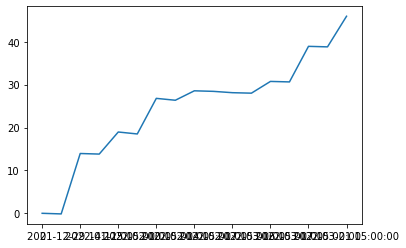

<AxesSubplot:>

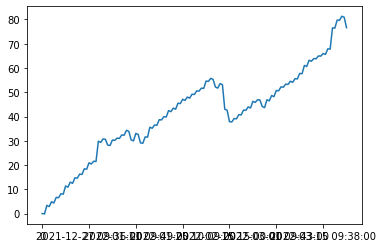

In [9]:
print(trade_res.keys())
import matplotlib.pyplot as plt

trade_res['0.045@0.003']['net value'].plot()
plt.show()

trade_res['0.0031@0']['net value'].plot()

In [10]:
df_grid_search_res =  pd.concat(list(grid_search_res.values()),axis=0)

In [11]:
df_grid_search_res.columns
df_grid_search_res

,cbond pair,convert price,win,lose,win profit,lose profit,sum of win&lose profit,final net value,win rate,profit ratio,...,avg round in a day,return per round,close by time,close by time win,close by time lose,close by signal,close by signal win,close by signal lose,open threshold,close threshold
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,113.797581,-37.183299,76.614282,76.614282,0.876923,0.429537,...,1.000000,0.003819,9.0,1.0,8.0,56.0,56.0,0.0,0.0031,0.000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,98.158387,-37.183299,60.975087,60.975087,0.876923,0.370505,...,1.000000,0.003048,8.0,0.0,8.0,57.0,57.0,0.0,0.0031,0.001
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,85.376013,-34.478700,50.897313,50.897313,0.876923,0.347536,...,1.000000,0.002541,7.0,0.0,7.0,58.0,57.0,1.0,0.0031,0.002
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,52.0,13.0,75.392424,-24.841546,50.550878,50.550878,0.800000,0.758733,...,1.000000,0.002536,6.0,0.0,6.0,59.0,52.0,7.0,0.0031,0.003
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,114.027087,-37.183299,76.843788,76.843788,0.876923,0.430403,...,1.000000,0.003828,9.0,1.0,8.0,56.0,56.0,0.0,0.0032,0.000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,98.391325,-37.183299,61.208026,61.208026,0.876923,0.371385,...,1.000000,0.003056,8.0,0.0,8.0,57.0,57.0,0.0,0.0032,0.001
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,84.706068,-34.478700,50.227368,50.227368,0.876923,0.344809,...,1.000000,0.002504,7.0,0.0,7.0,58.0,57.0,1.0,0.0032,0.002
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,53.0,12.0,74.712058,-24.831696,49.880362,49.880362,0.815385,0.681224,...,1.000000,0.002499,6.0,0.0,6.0,59.0,53.0,6.0,0.0032,0.003
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,116.904601,-37.183299,79.721302,79.721302,0.876923,0.441264,...,1.000000,0.003970,9.0,1.0,8.0,56.0,56.0,0.0,0.0035,0.000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,"[123046.SZ, 300587.SZ]",6.73,57.0,8.0,100.077634,-37.183299,62.894334,62.894334,0.876923,0.377750,...,1.000000,0.003138,8.0,0.0,8.0,57.0,57.0,0.0,0.0035,0.001


In [12]:
df_grid_search_res[['win','lose','total round',
                    'close by time','close by signal',
                    'close by time win','close by time lose',
                    'close by signal win','close by signal lose',
                    'open threshold', 'close threshold'
                    ]]

,win,lose,total round,close by time,close by signal,close by time win,close by time lose,close by signal win,close by signal lose,open threshold,close threshold
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,9.0,56.0,1.0,8.0,56.0,0.0,0.0031,0.000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,8.0,57.0,0.0,8.0,57.0,0.0,0.0031,0.001
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,7.0,58.0,0.0,7.0,57.0,1.0,0.0031,0.002
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,52.0,13.0,65.0,6.0,59.0,0.0,6.0,52.0,7.0,0.0031,0.003
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,9.0,56.0,1.0,8.0,56.0,0.0,0.0032,0.000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,8.0,57.0,0.0,8.0,57.0,0.0,0.0032,0.001
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,7.0,58.0,0.0,7.0,57.0,1.0,0.0032,0.002
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,53.0,12.0,65.0,6.0,59.0,0.0,6.0,53.0,6.0,0.0032,0.003
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,9.0,56.0,1.0,8.0,56.0,0.0,0.0035,0.000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,8.0,57.0,0.0,8.0,57.0,0.0,0.0035,0.001


In [13]:
tmp_grid_res = df_grid_search_res[['win','lose','total round',
                    'close by time','close by signal',
                    'close by time win','close by time lose',
                    'close by signal win','close by signal lose',
                    'open threshold', 'close threshold','win rate'
                    ]]

tmp_grid_res['close by time win/close by time'] = tmp_grid_res['close by time win']/tmp_grid_res['close by time']
tmp_grid_res['close by signal win/close by signal'] = tmp_grid_res['close by signal win']/tmp_grid_res['close by signal']
tmp_grid_res['close by time lose/lose'] = tmp_grid_res['close by time lose']/tmp_grid_res['lose']
# tmp_df.to_excel('')
tmp_grid_res.to_excel('tmp_grid_res.xlsx')
tmp_grid_res

,win,lose,total round,close by time,close by signal,close by time win,close by time lose,close by signal win,close by signal lose,open threshold,close threshold,win rate,close by time win/close by time,close by signal win/close by signal,close by time lose/lose
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,9.0,56.0,1.0,8.0,56.0,0.0,0.0031,0.000,0.876923,0.111111,1.000000,1.000000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,8.0,57.0,0.0,8.0,57.0,0.0,0.0031,0.001,0.876923,0.000000,1.000000,1.000000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,7.0,58.0,0.0,7.0,57.0,1.0,0.0031,0.002,0.876923,0.000000,0.982759,0.875000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,52.0,13.0,65.0,6.0,59.0,0.0,6.0,52.0,7.0,0.0031,0.003,0.800000,0.000000,0.881356,0.461538
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,9.0,56.0,1.0,8.0,56.0,0.0,0.0032,0.000,0.876923,0.111111,1.000000,1.000000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,8.0,57.0,0.0,8.0,57.0,0.0,0.0032,0.001,0.876923,0.000000,1.000000,1.000000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,7.0,58.0,0.0,7.0,57.0,1.0,0.0032,0.002,0.876923,0.000000,0.982759,0.875000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,53.0,12.0,65.0,6.0,59.0,0.0,6.0,53.0,6.0,0.0032,0.003,0.815385,0.000000,0.898305,0.500000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,9.0,56.0,1.0,8.0,56.0,0.0,0.0035,0.000,0.876923,0.111111,1.000000,1.000000
2021-12-14 09:30:00 -> 2022-03-22 15:00:00,57.0,8.0,65.0,8.0,57.0,0.0,8.0,57.0,0.0,0.0035,0.001,0.876923,0.000000,1.000000,1.000000


# return per round surface

In [14]:
df_return_per_round = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_return_per_round.loc[open_threshold,close_threshold] = row['return per round']
print('max return per round: \n',df_return_per_round.max())
print('min return per round: \n',df_return_per_round.min())
df_return_per_round

max return per round: 
 0.000    0.018918
0.001    0.018435
0.002    0.018435
0.003    0.018208
dtype: float64
min return per round: 
 0.000    0.003819
0.001    0.003048
0.002    0.002504
0.003    0.002499
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,0.003819,0.003048,0.002541,0.002536
0.0032,0.003828,0.003056,0.002504,0.002499
0.0035,0.003970,0.003138,0.002549,0.002534
0.0040,0.004176,0.003402,0.002633,0.002723
0.0050,0.004841,0.004030,0.003272,0.003263
0.0060,0.004911,0.004240,0.003803,0.003764
0.0070,0.004702,0.004069,0.004406,0.004339
0.0080,0.005262,0.004530,0.004902,0.004849
0.0090,0.005010,0.004293,0.004862,0.005213
0.0100,0.005195,0.004519,0.005195,0.004941


In [15]:
import plotly.graph_objects as go

x_data = df_return_per_round.columns.to_list() # close threshold

y_data = df_return_per_round.index.to_list() # open threshold

z_data = df_return_per_round.copy(deep=True) # return per round

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="return per round", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                 )

fig.show()

# win rate surface

In [16]:
df_win_rate = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_win_rate.loc[open_threshold,close_threshold] = row['win rate']
print('max win rate: \n',df_win_rate.max())
print('min win rate: \n',df_win_rate.min())    
df_win_rate

max win rate: 
 0.000    0.9
0.001    0.9
0.002    0.9
0.003    0.9
dtype: float64
min win rate: 
 0.000    0.577778
0.001    0.577778
0.002    0.622222
0.003    0.666667
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,0.876923,0.876923,0.876923,0.800000
0.0032,0.876923,0.876923,0.876923,0.815385
0.0035,0.876923,0.876923,0.876923,0.830769
0.0040,0.876923,0.876923,0.892308,0.892308
0.0050,0.861538,0.861538,0.876923,0.892308
0.0060,0.828125,0.828125,0.859375,0.875000
0.0070,0.781250,0.781250,0.828125,0.859375
0.0080,0.777778,0.777778,0.825397,0.857143
0.0090,0.737705,0.737705,0.786885,0.819672
0.0100,0.706897,0.706897,0.758621,0.775862


In [17]:
import plotly.graph_objects as go

x_data = df_win_rate.columns.to_list() # close threshold

y_data = df_win_rate.index.to_list() # open threshold

z_data = df_win_rate.copy(deep=True) # win rate

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="win rate", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                 )

fig.show()

# total round surface

In [18]:
df_total_round = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_total_round.loc[open_threshold,close_threshold] = row['total round']
print('max total round: \n',df_total_round.max())
print('min total round: \n',df_total_round.min())    
df_total_round

max total round: 
 0.000    65.0
0.001    65.0
0.002    65.0
0.003    65.0
dtype: float64
min total round: 
 0.000    8.0
0.001    8.0
0.002    8.0
0.003    8.0
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,65.0,65.0,65.0,65.0
0.0032,65.0,65.0,65.0,65.0
0.0035,65.0,65.0,65.0,65.0
0.0040,65.0,65.0,65.0,65.0
0.0050,65.0,65.0,65.0,65.0
0.0060,64.0,64.0,64.0,64.0
0.0070,64.0,64.0,64.0,64.0
0.0080,63.0,63.0,63.0,63.0
0.0090,61.0,61.0,61.0,61.0
0.0100,58.0,58.0,58.0,58.0


In [19]:
import plotly.graph_objects as go

x_data = df_total_round.columns.to_list() # close threshold

y_data = df_total_round.index.to_list() # open threshold

z_data = df_total_round.copy(deep=True) # win rate

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="total round", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                 )

fig.show()

# win round surface

In [20]:
df_win_round = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_win_round.loc[open_threshold,close_threshold] = row['win']
print('max win round: \n',df_win_round.max())
print('min win round: \n',df_win_round.min())    
df_win_round

max win round: 
 0.000    57.0
0.001    57.0
0.002    58.0
0.003    58.0
dtype: float64
min win round: 
 0.000    7.0
0.001    7.0
0.002    7.0
0.003    7.0
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,57.0,57.0,57.0,52.0
0.0032,57.0,57.0,57.0,53.0
0.0035,57.0,57.0,57.0,54.0
0.0040,57.0,57.0,58.0,58.0
0.0050,56.0,56.0,57.0,58.0
0.0060,53.0,53.0,55.0,56.0
0.0070,50.0,50.0,53.0,55.0
0.0080,49.0,49.0,52.0,54.0
0.0090,45.0,45.0,48.0,50.0
0.0100,41.0,41.0,44.0,45.0


In [21]:
import plotly.graph_objects as go

x_data = df_win_round.columns.to_list() # close threshold

y_data = df_win_round.index.to_list() # open threshold

z_data = df_win_round.copy(deep=True) # win rate

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="win round", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                 )

fig.show()

# lose round surface

In [22]:
df_lose_round = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_lose_round.loc[open_threshold,close_threshold] = row['lose']
print('max win round: \n',df_lose_round.max())
print('min win round: \n',df_lose_round.min())    
df_lose_round

max win round: 
 0.000    19.0
0.001    19.0
0.002    17.0
0.003    15.0
dtype: float64
min win round: 
 0.000    1.0
0.001    1.0
0.002    1.0
0.003    1.0
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,8.0,8.0,8.0,13.0
0.0032,8.0,8.0,8.0,12.0
0.0035,8.0,8.0,8.0,11.0
0.0040,8.0,8.0,7.0,7.0
0.0050,9.0,9.0,8.0,7.0
0.0060,11.0,11.0,9.0,8.0
0.0070,14.0,14.0,11.0,9.0
0.0080,14.0,14.0,11.0,9.0
0.0090,16.0,16.0,13.0,11.0
0.0100,17.0,17.0,14.0,13.0


In [23]:
import plotly.graph_objects as go

x_data = df_lose_round.columns.to_list() # close threshold

y_data = df_lose_round.index.to_list() # open threshold

z_data = df_lose_round.copy(deep=True) # win rate

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="lose round", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                )

fig.show()

# net value surface

In [24]:
'final net value'
df_final_nv = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_final_nv.loc[open_threshold,close_threshold] = row['final net value']
print('max return per round: \n',df_final_nv.max())
print('min return per round: \n',df_final_nv.min())
df_final_nv


max return per round: 
 0.000    102.900400
0.001     88.472921
0.002     95.586726
0.003     98.796285
dtype: float64
min return per round: 
 0.000    44.013887
0.001    42.668619
0.002    42.668619
0.003    42.037501
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,76.614282,60.975087,50.897313,50.550878
0.0032,76.843788,61.208026,50.227368,49.880362
0.0035,79.721302,62.894334,51.152164,50.607326
0.0040,83.934335,68.303140,52.774789,54.420189
0.0050,97.919042,81.582014,66.189049,65.820555
0.0060,98.326247,85.009741,76.121156,75.199427
0.0070,93.410214,80.740760,87.175675,86.111249
0.0080,102.900400,88.472921,95.586726,94.851926
0.0090,94.627933,80.978356,91.765061,98.796285
0.0100,93.764260,81.511629,93.648650,89.158367


In [25]:
import plotly.graph_objects as go

x_data = df_final_nv.columns.to_list() # close threshold

y_data = df_final_nv.index.to_list() # open threshold

z_data = df_final_nv.copy(deep=True) # return per round

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="final net value", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                 )

fig.show()

# breadth analysis

In [26]:
df_grid_search_res['signal breadth'] = df_grid_search_res['open threshold'] - df_grid_search_res['close threshold']
# tmp_grid_res['signal breadth'] = tmp_grid_res['open threshold'] - tmp_grid_res['close threshold']

In [27]:
tmp_grid_res
df_breadth = pd.DataFrame([])
for index,row in df_grid_search_res.iterrows():
    open_threshold = row['open threshold']
    close_threshold = row['close threshold']
    df_breadth.loc[open_threshold,close_threshold] = row['signal breadth']
print('max signal breadth: \n',df_breadth.max())
print('min signal breadth: \n',df_breadth.min())    
df_breadth

max signal breadth: 
 0.000    0.045
0.001    0.044
0.002    0.043
0.003    0.042
dtype: float64
min signal breadth: 
 0.000    0.0031
0.001    0.0021
0.002    0.0011
0.003    0.0001
dtype: float64


,0.000,0.001,0.002,0.003
0.0031,0.0031,0.0021,0.0011,0.0001
0.0032,0.0032,0.0022,0.0012,0.0002
0.0035,0.0035,0.0025,0.0015,0.0005
0.0040,0.0040,0.0030,0.0020,0.0010
0.0050,0.0050,0.0040,0.0030,0.0020
0.0060,0.0060,0.0050,0.0040,0.0030
0.0070,0.0070,0.0060,0.0050,0.0040
0.0080,0.0080,0.0070,0.0060,0.0050
0.0090,0.0090,0.0080,0.0070,0.0060
0.0100,0.0100,0.0090,0.0080,0.0070


In [28]:
import plotly.graph_objects as go

x_data = df_breadth.columns.to_list() # close threshold

y_data = df_breadth.index.to_list() # open threshold

z_data = df_breadth.copy(deep=True) # win rate

fig = go.Figure(data=[go.Surface(z=z_data.values,x=x_data,y=y_data)])

fig.update_layout(title="signal breadth", # 标题
                  autosize=False,  # 尺度自动缩放
                  width=700,  # 长宽
                  height=600,
                  margin=dict(l=65,r=50,b=65,t=90),  # 4个位置的距离
                  scene=dict(xaxis_title='X-close-threshold',yaxis_title='Y-open-threshold')
                )

fig.show()

In [29]:
df_grid_search_res['scatter label'] = list(trade_res.keys())

import plotly.express as px
fig = px.scatter(df_grid_search_res,x='signal breadth', y='win rate',
                # marginal_x="histogram",
                # text=df_grid_search_res['scatter label'].tolist()
                )
fig.show()
# tmp_grid_res.plot.scatter(x='signal breadth',y='win rate',s=10)

In [30]:
tmp_grid_res = df_grid_search_res[df_grid_search_res['close threshold']==0.003]

import plotly.express as px
fig = px.scatter(tmp_grid_res,x='signal breadth', y='win rate',
                # marginal_x="histogram",
                text=tmp_grid_res['scatter label'].tolist()
                )
fig.show()

In [31]:
tmp_grid_res = df_grid_search_res[df_grid_search_res['close threshold']==0]

import plotly.express as px
fig = px.scatter(tmp_grid_res,x='signal breadth', y='return per round',
                # marginal_x="histogram",
                text=tmp_grid_res['scatter label'].tolist()
                )
fig.show()

In [32]:
tmp_grid_res = df_grid_search_res[df_grid_search_res['close threshold']==0]
# tmp_grid_res = df_grid_search_res

import plotly.express as px
fig = px.scatter(tmp_grid_res,x='signal breadth', y='final net value',
                # marginal_x="histogram",
                text=tmp_grid_res['scatter label'].tolist()
                )
fig.show()

In [33]:
# (330 + 18x14.88) x (2/10000)
#  (334/330 - 1 ) - (18/17.6-1)  

In [34]:
import plotly.express as px

fig = px.scatter_3d(tmp_grid_res, 
                    x='return per round', 
                    y='signal breadth',
                    z='win rate',
                    # color='species'
                    size='win rate'
                  )
fig.show()

# signal check

In [35]:
print('open threshold: ',open_threshold,'close threshold: ',close_threshold)
# df_signal

open threshold:  0.045 close threshold:  0.003


In [36]:
len(rounds)

8

In [37]:
cnt = 0
for index, row in df_trade.iterrows():
    
    if str(index)[-8:] == '15:00:00':
        cnt += 1
print(cnt)

7


In [38]:
df_pos_list = []
for k,v in signal_res.items():
    # print(k.split('@'))
    tmp_df_pos = v[['bond_pos','stock_pos']]
    # print(tmp_df_pos.head())
    tmp_df_pos.columns = ['bond_pos'+k,'stock_pos']
    df_pos_list.append(tmp_df_pos)


In [39]:
df_pos = pd.concat([df_signal.iloc[:,:-2],df_pos_list[0],df_pos_list[-4]],axis=1)
print(len(df_pos))
df_pos.head(300)

14873


,bond_price,stock_price,bond_rtn,stock_rtn,diff,bond_pos0.0031@0,stock_pos,bond_pos0.045@0,stock_pos
2021-12-13 15:00:00,350.180,20.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2021-12-14 09:30:00,351.144,19.95,0.002753,-0.002500,0.005253,-1.0,1.0,0.0,0.0
2021-12-14 09:31:00,351.370,19.96,0.003398,-0.002000,0.005398,-1.0,1.0,0.0,0.0
2021-12-14 09:32:00,351.368,19.94,0.003393,-0.003000,0.006393,-1.0,1.0,0.0,0.0
2021-12-14 09:33:00,351.005,19.99,0.002356,-0.000500,0.002856,-1.0,1.0,0.0,0.0
2021-12-14 09:34:00,348.547,20.01,-0.004663,0.000500,-0.005163,0.0,0.0,0.0,0.0
2021-12-14 09:35:00,348.900,19.97,-0.003655,-0.001500,-0.002155,0.0,0.0,0.0,0.0
2021-12-14 09:36:00,350.196,20.07,0.000046,0.003500,-0.003454,0.0,0.0,0.0,0.0
2021-12-14 09:37:00,350.226,20.08,0.000131,0.004000,-0.003869,0.0,0.0,0.0,0.0
2021-12-14 09:38:00,351.280,20.02,0.003141,0.001000,0.002141,0.0,0.0,0.0,0.0
